# Backcasting
> This notebook is built on top of Time Series Regression notebook. Here, backcasting is performed in addition to forecasting to improve performance on test set.

> Backcasting is performed by simply selecting data ahead in time (to test data), and reversing the time order.

## Pre-processing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
# Loading the data
load_long = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\load_history_long.csv").sort_values(by = "timestamp")

# Filtering for Zone 1, applying log transformation on load (after rescaling)
load_long_z1 = load_long
load_long_z1["load_rs"] = load_long_z1.load / 1000
load_long_z1["log_load_rs"] = np.log(load_long_z1.load_rs)
load_long_z1 = load_long_z1.loc[load_long_z1.zone_id == 1,:].sort_values(by = "timestamp").reset_index(drop=True)

# Loading the temperature data
temperature = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\weighted_temperature.csv")

# Importing holiday dataframe
holiday_df = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Dataset\GEFCom2012\GEFCOM2012_Data\Load\Holiday_List.csv")

# Filtering load for 2004
load_long_z1_2004 = load_long_z1.loc[load_long_z1.year == 2004, ['timestamp','year','month','day','hour','log_load_rs']]

# Filtering temperature for 2004
temperature_2004 = temperature.loc[temperature.timestamp <= '2004-12-31 23:30:00', ['timestamp', 'temp_weighted']]

# Combining load and temperature information
mul_df = load_long_z1_2004.merge(temperature_2004, on='timestamp', how='left')

# Adding holiday column
mul_df["holiday"] = 0

# Adding holiday information - for 2004
mul_df.loc[mul_df.timestamp <= "2004-01-01 23:30:00","holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-01-19 23:30:00") & (mul_df.timestamp >= "2004-01-19 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-02-16 23:30:00") & (mul_df.timestamp >= "2004-02-16 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-05-31 23:30:00") & (mul_df.timestamp >= "2004-05-31 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-07-05 23:30:00") & (mul_df.timestamp >= "2004-07-05 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-09-06 23:30:00") & (mul_df.timestamp >= "2004-09-06 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-10-11 23:30:00") & (mul_df.timestamp >= "2004-10-11 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-11-11 23:30:00") & (mul_df.timestamp >= "2004-11-11 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-11-25 23:30:00") & (mul_df.timestamp >= "2004-11-25 00:30:00"),"holiday"] = 1
mul_df.loc[(mul_df.timestamp <= "2004-12-24 23:30:00") & (mul_df.timestamp >= "2004-12-24 00:30:00"),"holiday"] = 1
mul_df.head()

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,timestamp,year,month,day,hour,log_load_rs,temp_weighted,holiday
0,2004-01-01 00:30:00,2004,1,1,00:30,2.824529,42.338937,1
1,2004-01-01 01:30:00,2004,1,1,01:30,2.800325,41.239284,1
2,2004-01-01 02:30:00,2004,1,1,02:30,2.804390,39.591442,1
3,2004-01-01 03:30:00,2004,1,1,03:30,2.825715,36.243296,1
4,2004-01-01 04:30:00,2004,1,1,04:30,2.836971,34.600850,1


In [3]:
# Adding temperature knots for PLR

T_H = 55  # Heating Threshold
T_C = 65  # Cooling Threshold

# Construct the Heating Demand Knot: HDK = max(0, T_H - Temp)
## This captures load increase when temp is below T_H.
mul_df["HDK"] = np.where(
    mul_df["temp_weighted"] < T_H,  
    T_H - mul_df["temp_weighted"],  # Value if True: The positive difference
    0                               # Value if False: Zero
)

# Construct the Cooling Demand Knot; CDK = max(0, Temp - T_C)
## This captures load increase when temp is above T_C.
mul_df["CDK"] = np.where(
    mul_df["temp_weighted"] > T_C,  
    mul_df["temp_weighted"] - T_C,  # Value if True: The positive difference
    0                               # Value if False: Zero
)

mul_df.head()

,timestamp,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK
0,2004-01-01 00:30:00,2004,1,1,00:30,2.824529,42.338937,1,12.661063,0.0
1,2004-01-01 01:30:00,2004,1,1,01:30,2.800325,41.239284,1,13.760716,0.0
2,2004-01-01 02:30:00,2004,1,1,02:30,2.804390,39.591442,1,15.408558,0.0
3,2004-01-01 03:30:00,2004,1,1,03:30,2.825715,36.243296,1,18.756704,0.0
4,2004-01-01 04:30:00,2004,1,1,04:30,2.836971,34.600850,1,20.399150,0.0


## Time Series Regression (PLR + Harmonics)
Here two training sets are used. First one forecasts for test set and the other one backcasts for the same test set.
> Training length for both sets are 3 weeks, each.

### Testing on Last Week of Jan 2004 (Zone 1)

In [4]:
# Creating training data 1
load_long_z1_2004_jan_train = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.set_index("timestamp")
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train[:'2004-01-24 23:30:00']
load_long_z1_2004_jan_train.index = pd.to_datetime(load_long_z1_2004_jan_train.index)

# Creating training data 2
load_long_z1_2004_feb_train = mul_df.loc[mul_df.month == 2,:]
load_long_z1_2004_feb_train = load_long_z1_2004_feb_train.set_index("timestamp")
load_long_z1_2004_feb_train = load_long_z1_2004_feb_train[:'2004-02-21 23:30:00']
load_long_z1_2004_feb_train.index = pd.to_datetime(load_long_z1_2004_feb_train.index)

# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave (training set 1)
dp1 = DeterministicProcess(
    index=load_long_z1_2004_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves1 = dp1.in_sample()

# Defining the sine wave (training set 2)
dp2 = DeterministicProcess(
    index=load_long_z1_2004_feb_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves2 = dp2.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_jan_train = load_long_z1_2004_jan_train.merge(waves1, on='timestamp', how='left')
load_long_z1_2004_feb_train = load_long_z1_2004_feb_train.merge(waves2, on='timestamp', how='left')

In [5]:
# Fitting Linear Regression Model - training set 1 
from sklearn.linear_model import LinearRegression

X_train1 = load_long_z1_2004_jan_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train1 = np.array(load_long_z1_2004_jan_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_jan_train_reg = LinearRegression().fit(X_train1, y_train1)

# Fitting Linear Regression Model - training set 2
X_train2 = load_long_z1_2004_feb_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train2 = np.array(load_long_z1_2004_feb_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_feb_train_reg = LinearRegression().fit(X_train2, y_train2)

In [6]:
# Creating test data
load_long_z1_2004_jan_test = mul_df.loc[mul_df.month == 1,:]
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.set_index("timestamp")
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test['2004-01-25 00:30:00':]
load_long_z1_2004_jan_test.index = pd.to_datetime(load_long_z1_2004_jan_test.index)

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jan_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_jan_test = load_long_z1_2004_jan_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jan_test.head()

,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK,trend,"sin(1,24)","cos(1,24)","sin(2,24)","cos(2,24)"
timestamp,,,,,,,,,,,,,,
2004-01-25 00:30:00,2004,1,25,00:30,3.094174,21.155292,0,33.844708,0.0,1.0,0.000000,1.000000,0.000000,1.000000e+00
2004-01-25 01:30:00,2004,1,25,01:30,3.101713,20.058817,0,34.941183,0.0,2.0,0.258819,0.965926,0.500000,8.660254e-01
2004-01-25 02:30:00,2004,1,25,02:30,3.144626,19.051006,0,35.948994,0.0,3.0,0.500000,0.866025,0.866025,5.000000e-01
2004-01-25 03:30:00,2004,1,25,03:30,3.160441,18.246300,0,36.753700,0.0,4.0,0.707107,0.707107,1.000000,6.123234e-17
2004-01-25 04:30:00,2004,1,25,04:30,3.197407,17.700175,0,37.299825,0.0,5.0,0.866025,0.500000,0.866025,-5.000000e-01


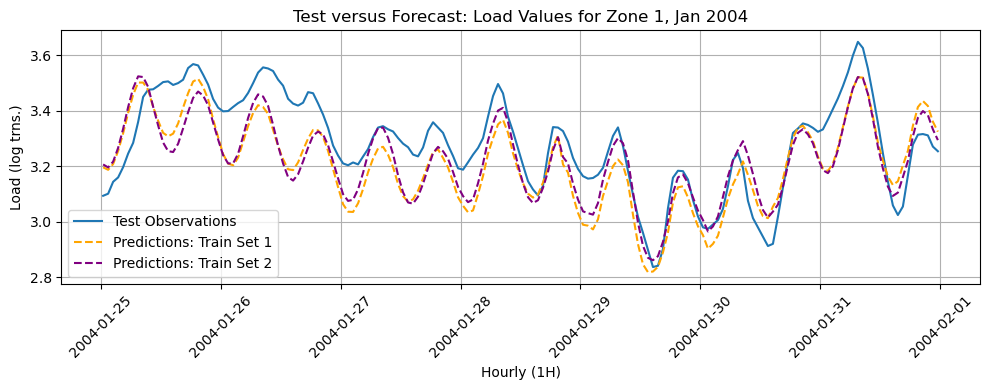

In [36]:
# Defining feature space and dependent variable - test set
y_test = load_long_z1_2004_jan_test["log_load_rs"]
X_test = load_long_z1_2004_jan_test[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]

# Predicted Values - Both Models
y_pred1 = np.ravel(np.array(load_long_z1_2004_jan_train_reg.predict(X_test)))
y_pred2 = np.ravel(np.array(load_long_z1_2004_feb_train_reg.predict(X_test)))

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=np.ravel(np.array(load_long_z1_2004_jan_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred1, x=load_long_z1_2004_jan_test.index, linestyle = '--', color='orange', label="Predictions: Train Set 1")
sns.lineplot(y=y_pred2, x=load_long_z1_2004_jan_test.index, linestyle = '--', color='purple', label="Predictions: Train Set 2")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

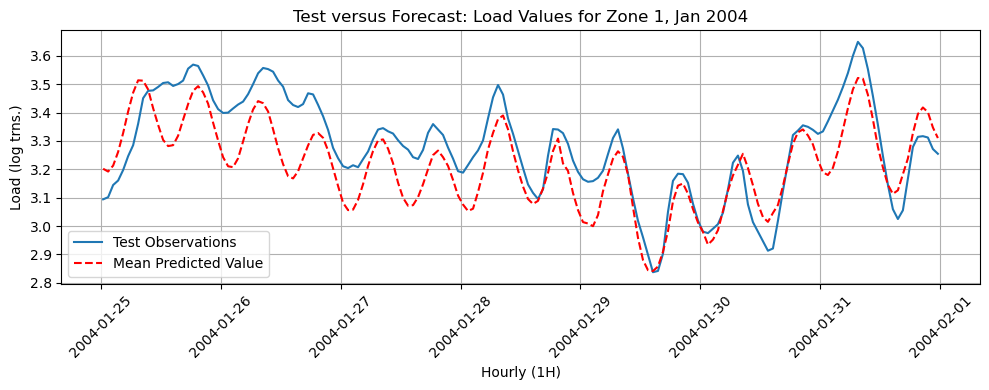

In [8]:
# Fit on the test data - from mean prediction
y_pred = (y_pred1 + y_pred2) / 2

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jan_test, x=load_long_z1_2004_jan_test.index, y=np.ravel(np.array(load_long_z1_2004_jan_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred, x=load_long_z1_2004_jan_test.index, linestyle = '--', color='red', label="Mean Predicted Value")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jan 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# Averaging both predictions and testing performance on test
y_pred = (y_pred1 + y_pred2) / 2

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.5686851882935278
MSE score: 0.013173018246023117
MAE score: 0.09765860601415871
MAPE score: 0.029414123049807717


Slight performance increase.

In [14]:
# if first half of predictions come from set 1 and other half from set 2, does it improve performance?

print(f"R2 score: {r2_score(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}")
print(f'MSE score: {mean_squared_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAE score: {mean_absolute_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')

R2 score: 0.5746562617024105
MSE score: 0.012990652473207773
MAE score: 0.09688282509745669
MAPE score: 0.02918382674959725


Slight performance increase.

In [39]:
# Can combined training improve test performance?

## Combined training - training set 1 + training set 2
load_long_z1_2004_jan_train_com = pd.concat([load_long_z1_2004_jan_train, load_long_z1_2004_feb_train])

## Fitting Linear Regression Model - combined training
X_train_com = load_long_z1_2004_jan_train_com[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train_com = np.array(load_long_z1_2004_jan_train_com.log_load_rs).reshape(-1, 1)
load_long_z1_2004_jan_train_com_reg = LinearRegression().fit(X_train_com, y_train_com)

## Predicting
y_pred = np.ravel(np.array(load_long_z1_2004_jan_train_com_reg.predict(X_test)))

## Performance on test
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.5811740738233718
MSE score: 0.01279158845856409
MAE score: 0.09716075863593299
MAPE score: 0.0293309146853319


There is slight performance increase.

### Testing on Last Week of Apr 2004 (Zone 1)

In [15]:
# Creating training data 1
load_long_z1_2004_apr_train = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.set_index("timestamp")
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train[:'2004-04-23 23:30:00']
load_long_z1_2004_apr_train.index = pd.to_datetime(load_long_z1_2004_apr_train.index)

# Creating training data 2
load_long_z1_2004_may_train = mul_df.loc[mul_df.month == 5,:]
load_long_z1_2004_may_train = load_long_z1_2004_may_train.set_index("timestamp")
load_long_z1_2004_may_train = load_long_z1_2004_may_train[:'2004-05-21 23:30:00']
load_long_z1_2004_may_train.index = pd.to_datetime(load_long_z1_2004_may_train.index)

# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave (training set 1)
dp1 = DeterministicProcess(
    index=load_long_z1_2004_apr_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves1 = dp1.in_sample()

# Defining the sine wave (training set 2)
dp2 = DeterministicProcess(
    index=load_long_z1_2004_may_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves2 = dp2.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_apr_train = load_long_z1_2004_apr_train.merge(waves1, on='timestamp', how='left')
load_long_z1_2004_may_train = load_long_z1_2004_may_train.merge(waves2, on='timestamp', how='left')

In [16]:
# Fitting Linear Regression Model - training set 1 
from sklearn.linear_model import LinearRegression

X_train1 = load_long_z1_2004_apr_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train1 = np.array(load_long_z1_2004_apr_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_apr_train_reg = LinearRegression().fit(X_train1, y_train1)

# Fitting Linear Regression Model - training set 2
X_train2 = load_long_z1_2004_may_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train2 = np.array(load_long_z1_2004_may_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_may_train_reg = LinearRegression().fit(X_train2, y_train2)

In [17]:
# Creating test data
load_long_z1_2004_apr_test = mul_df.loc[mul_df.month == 4,:]
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.set_index("timestamp")
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test['2004-04-24 00:30:00':]
load_long_z1_2004_apr_test.index = pd.to_datetime(load_long_z1_2004_apr_test.index)

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_apr_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_apr_test = load_long_z1_2004_apr_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_apr_test.head()

,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK,trend,"sin(1,24)","cos(1,24)","sin(2,24)","cos(2,24)"
timestamp,,,,,,,,,,,,,,
2004-04-24 00:30:00,2004,4,24,00:30,2.437728,62.266565,0,0.0,0.0,1.0,0.000000,1.000000,0.000000,1.000000e+00
2004-04-24 01:30:00,2004,4,24,01:30,2.328643,62.708075,0,0.0,0.0,2.0,0.258819,0.965926,0.500000,8.660254e-01
2004-04-24 02:30:00,2004,4,24,02:30,2.279316,61.449205,0,0.0,0.0,3.0,0.500000,0.866025,0.866025,5.000000e-01
2004-04-24 03:30:00,2004,4,24,03:30,2.249290,60.634717,0,0.0,0.0,4.0,0.707107,0.707107,1.000000,6.123234e-17
2004-04-24 04:30:00,2004,4,24,04:30,2.248657,59.824237,0,0.0,0.0,5.0,0.866025,0.500000,0.866025,-5.000000e-01


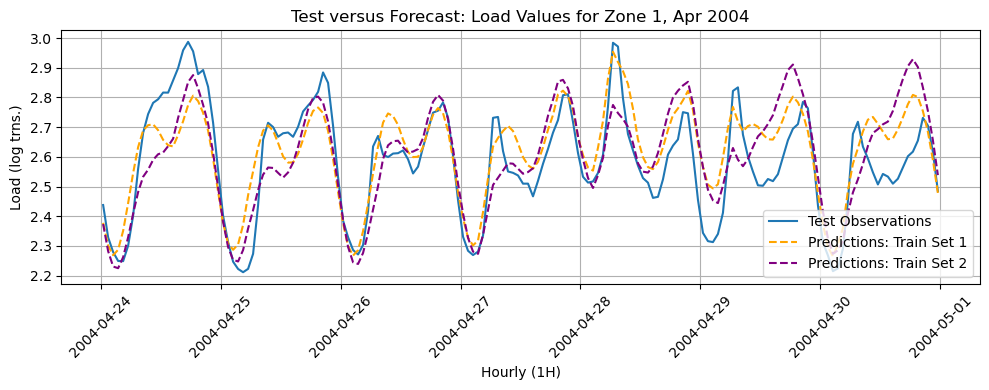

In [40]:
# Defining feature space and dependent variable - test set
y_test = load_long_z1_2004_apr_test["log_load_rs"]
X_test = load_long_z1_2004_apr_test[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]

# Predicted Values - Both Models
y_pred1 = np.ravel(np.array(load_long_z1_2004_apr_train_reg.predict(X_test)))
y_pred2 = np.ravel(np.array(load_long_z1_2004_may_train_reg.predict(X_test)))

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=np.ravel(np.array(load_long_z1_2004_apr_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred1, x=load_long_z1_2004_apr_test.index, linestyle = '--', color='orange', label="Predictions: Train Set 1")
sns.lineplot(y=y_pred2, x=load_long_z1_2004_apr_test.index, linestyle = '--', color='purple', label="Predictions: Train Set 2")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

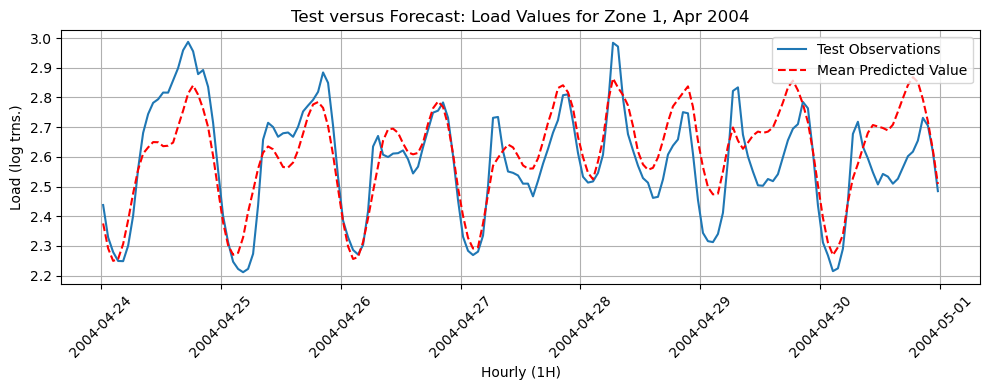

In [19]:
# Fit on the test data - from mean prediction
y_pred = (y_pred1 + y_pred2) / 2

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_apr_test, x=load_long_z1_2004_apr_test.index, y=np.ravel(np.array(load_long_z1_2004_apr_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred, x=load_long_z1_2004_apr_test.index, linestyle = '--', color='red', label="Mean Predicted Value")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Apr 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [20]:
# Averaging both predictions and testing performance on test
y_pred = (y_pred1 + y_pred2) / 2

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.6495592987323944
MSE score: 0.011987204269411886
MAE score: 0.0893021652888023
MAPE score: 0.034462465247308546


Similar Performance.

In [21]:
# if first half of predictions come from set 1 and other half from set 2, does it improve performance?

print(f"R2 score: {r2_score(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}")
print(f'MSE score: {mean_squared_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAE score: {mean_absolute_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')

R2 score: 0.5322870902084993
MSE score: 0.015998627353591588
MAE score: 0.10037332032720381
MAPE score: 0.038752813348667384


Performance decreased.

In [41]:
# Can combined training improve test performance?

## Combined training - training set 1 + training set 2
load_long_z1_2004_apr_train_com = pd.concat([load_long_z1_2004_apr_train, load_long_z1_2004_may_train])

## Fitting Linear Regression Model - combined training
X_train_com = load_long_z1_2004_apr_train_com[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train_com = np.array(load_long_z1_2004_apr_train_com.log_load_rs).reshape(-1, 1)
load_long_z1_2004_apr_train_com_reg = LinearRegression().fit(X_train_com, y_train_com)

## Predicting
y_pred = np.ravel(np.array(load_long_z1_2004_apr_train_com_reg.predict(X_test)))

## Performance on test
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.6270729039757077
MSE score: 0.01275637579045961
MAE score: 0.09212367112990966
MAPE score: 0.03576158617438557


Performance not better than mean prediction.

### Testing on Last Week of Jul 2004 (Zone 1)

In [22]:
# Creating training data 1
load_long_z1_2004_jul_train = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.set_index("timestamp")
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train[:'2004-07-24 23:30:00']
load_long_z1_2004_jul_train.index = pd.to_datetime(load_long_z1_2004_jul_train.index)

# Creating training data 2
load_long_z1_2004_aug_train = mul_df.loc[mul_df.month == 8,:]
load_long_z1_2004_aug_train = load_long_z1_2004_aug_train.set_index("timestamp")
load_long_z1_2004_aug_train = load_long_z1_2004_aug_train[:'2004-08-21 23:30:00']
load_long_z1_2004_aug_train.index = pd.to_datetime(load_long_z1_2004_aug_train.index)

# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave (training set 1)
dp1 = DeterministicProcess(
    index=load_long_z1_2004_jul_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves1 = dp1.in_sample()

# Defining the sine wave (training set 2)
dp2 = DeterministicProcess(
    index=load_long_z1_2004_aug_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves2 = dp2.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_jul_train = load_long_z1_2004_jul_train.merge(waves1, on='timestamp', how='left')
load_long_z1_2004_aug_train = load_long_z1_2004_aug_train.merge(waves2, on='timestamp', how='left')

In [23]:
# Fitting Linear Regression Model - training set 1 
from sklearn.linear_model import LinearRegression

X_train1 = load_long_z1_2004_jul_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train1 = np.array(load_long_z1_2004_jul_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_jul_train_reg = LinearRegression().fit(X_train1, y_train1)

# Fitting Linear Regression Model - training set 2
X_train2 = load_long_z1_2004_aug_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train2 = np.array(load_long_z1_2004_aug_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_aug_train_reg = LinearRegression().fit(X_train2, y_train2)

In [24]:
# Creating test data
load_long_z1_2004_jul_test = mul_df.loc[mul_df.month == 7,:]
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.set_index("timestamp")
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test['2004-07-25 00:30:00':]
load_long_z1_2004_jul_test.index = pd.to_datetime(load_long_z1_2004_jul_test.index)

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_jul_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_jul_test = load_long_z1_2004_jul_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_jul_test.head()

,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK,trend,"sin(1,24)","cos(1,24)","sin(2,24)","cos(2,24)"
timestamp,,,,,,,,,,,,,,
2004-07-25 00:30:00,2004,7,25,00:30,2.669517,70.616043,0,0.0,5.616043,1.0,0.000000,1.000000,0.000000,1.000000e+00
2004-07-25 01:30:00,2004,7,25,01:30,2.551552,70.893317,0,0.0,5.893317,2.0,0.258819,0.965926,0.500000,8.660254e-01
2004-07-25 02:30:00,2004,7,25,02:30,2.486073,70.710504,0,0.0,5.710504,3.0,0.500000,0.866025,0.866025,5.000000e-01
2004-07-25 03:30:00,2004,7,25,03:30,2.441738,70.526899,0,0.0,5.526899,4.0,0.707107,0.707107,1.000000,6.123234e-17
2004-07-25 04:30:00,2004,7,25,04:30,2.429834,70.527349,0,0.0,5.527349,5.0,0.866025,0.500000,0.866025,-5.000000e-01


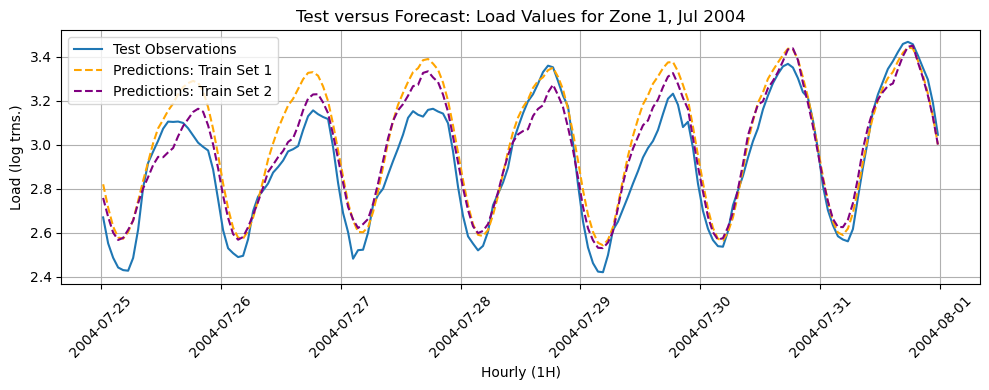

In [43]:
# Defining feature space and dependent variable - test set
y_test = load_long_z1_2004_jul_test["log_load_rs"]
X_test = load_long_z1_2004_jul_test[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]

# Predicted Values - Both Models
y_pred1 = np.ravel(np.array(load_long_z1_2004_jul_train_reg.predict(X_test)))
y_pred2 = np.ravel(np.array(load_long_z1_2004_aug_train_reg.predict(X_test)))

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=np.ravel(np.array(load_long_z1_2004_jul_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred1, x=load_long_z1_2004_jul_test.index, linestyle = '--', color='orange', label="Predictions: Train Set 1")
sns.lineplot(y=y_pred2, x=load_long_z1_2004_jul_test.index, linestyle = '--', color='purple', label="Predictions: Train Set 2")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

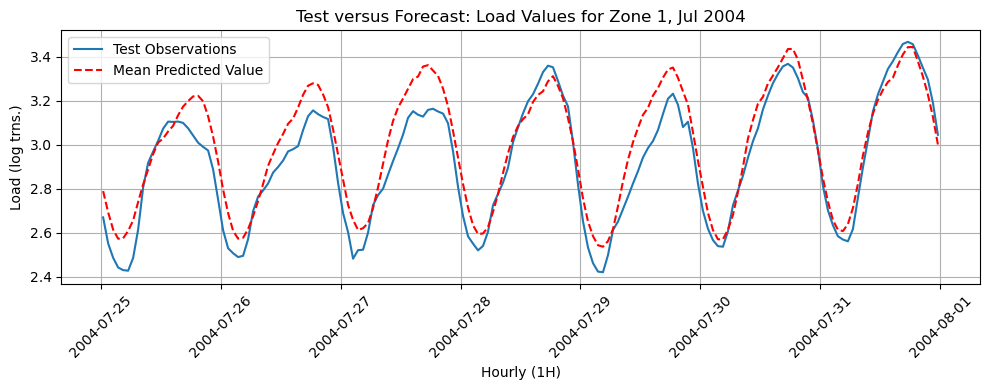

In [26]:
# Fit on the test data - from mean prediction
y_pred = (y_pred1 + y_pred2) / 2

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_jul_test, x=load_long_z1_2004_jul_test.index, y=np.ravel(np.array(load_long_z1_2004_jul_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred, x=load_long_z1_2004_jul_test.index, linestyle = '--', color='red', label="Mean Predicted Value")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Jul 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# Averaging both predictions and testing performance on test
y_pred = (y_pred1 + y_pred2) / 2

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.8574716935318502
MSE score: 0.011256278198172962
MAE score: 0.08885028151797776
MAPE score: 0.030932931035522023


Performance has improved.

In [28]:
# if first half of predictions come from set 1 and other half from set 2, does it improve performance?

print(f"R2 score: {r2_score(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}")
print(f'MSE score: {mean_squared_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAE score: {mean_absolute_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')

R2 score: 0.816956176257872
MSE score: 0.014456021077884322
MAE score: 0.10094780370772265
MAPE score: 0.03486110913273911


Performance not better than averaged prediction.

In [44]:
# Can combined training improve test performance?

## Combined training - training set 1 + training set 2
load_long_z1_2004_jul_train_com = pd.concat([load_long_z1_2004_jul_train, load_long_z1_2004_aug_train])

## Fitting Linear Regression Model - combined training
X_train_com = load_long_z1_2004_jul_train_com[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train_com = np.array(load_long_z1_2004_jul_train_com.log_load_rs).reshape(-1, 1)
load_long_z1_2004_jul_train_com_reg = LinearRegression().fit(X_train_com, y_train_com)

## Predicting
y_pred = np.ravel(np.array(load_long_z1_2004_jul_train_com_reg.predict(X_test)))

## Performance on test
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.8781235898812016
MSE score: 0.009625279441585049
MAE score: 0.08471232805817097
MAPE score: 0.02954895584544815


Performance better than above 2 cases.

### Testing on Last Week of Oct 2004 (Zone 1)

In [29]:
# Creating training data 1
load_long_z1_2004_oct_train = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.set_index("timestamp")
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train[:'2004-10-24 23:30:00']
load_long_z1_2004_oct_train.index = pd.to_datetime(load_long_z1_2004_oct_train.index)

# Creating training data 2
load_long_z1_2004_nov_train = mul_df.loc[mul_df.month == 11,:]
load_long_z1_2004_nov_train = load_long_z1_2004_nov_train.set_index("timestamp")
load_long_z1_2004_nov_train = load_long_z1_2004_nov_train[:'2004-11-21 23:30:00']
load_long_z1_2004_nov_train.index = pd.to_datetime(load_long_z1_2004_nov_train.index)

# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave (training set 1)
dp1 = DeterministicProcess(
    index=load_long_z1_2004_oct_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves1 = dp1.in_sample()

# Defining the sine wave (training set 2)
dp2 = DeterministicProcess(
    index=load_long_z1_2004_nov_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves2 = dp2.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_oct_train = load_long_z1_2004_oct_train.merge(waves1, on='timestamp', how='left')
load_long_z1_2004_nov_train = load_long_z1_2004_nov_train.merge(waves2, on='timestamp', how='left')

In [30]:
# Fitting Linear Regression Model - training set 1 
from sklearn.linear_model import LinearRegression

X_train1 = load_long_z1_2004_oct_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train1 = np.array(load_long_z1_2004_oct_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_oct_train_reg = LinearRegression().fit(X_train1, y_train1)

# Fitting Linear Regression Model - training set 2
X_train2 = load_long_z1_2004_nov_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train2 = np.array(load_long_z1_2004_nov_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_nov_train_reg = LinearRegression().fit(X_train2, y_train2)

In [31]:
# Creating test data
load_long_z1_2004_oct_test = mul_df.loc[mul_df.month == 10,:]
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.set_index("timestamp")
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test['2004-10-25 00:30:00':]
load_long_z1_2004_oct_test.index = pd.to_datetime(load_long_z1_2004_oct_test.index)

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_oct_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_oct_test = load_long_z1_2004_oct_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_oct_test.head()

,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK,trend,"sin(1,24)","cos(1,24)","sin(2,24)","cos(2,24)"
timestamp,,,,,,,,,,,,,,
2004-10-25 00:30:00,2004,10,25,00:30,2.449970,50.290127,0,4.709873,0.0,1.0,0.000000,1.000000,0.000000,1.000000e+00
2004-10-25 01:30:00,2004,10,25,01:30,2.407305,50.291859,0,4.708141,0.0,2.0,0.258819,0.965926,0.500000,8.660254e-01
2004-10-25 02:30:00,2004,10,25,02:30,2.395164,50.658222,0,4.341778,0.0,3.0,0.500000,0.866025,0.866025,5.000000e-01
2004-10-25 03:30:00,2004,10,25,03:30,2.396531,50.571048,0,4.428952,0.0,4.0,0.707107,0.707107,1.000000,6.123234e-17
2004-10-25 04:30:00,2004,10,25,04:30,2.434403,50.467636,0,4.532364,0.0,5.0,0.866025,0.500000,0.866025,-5.000000e-01


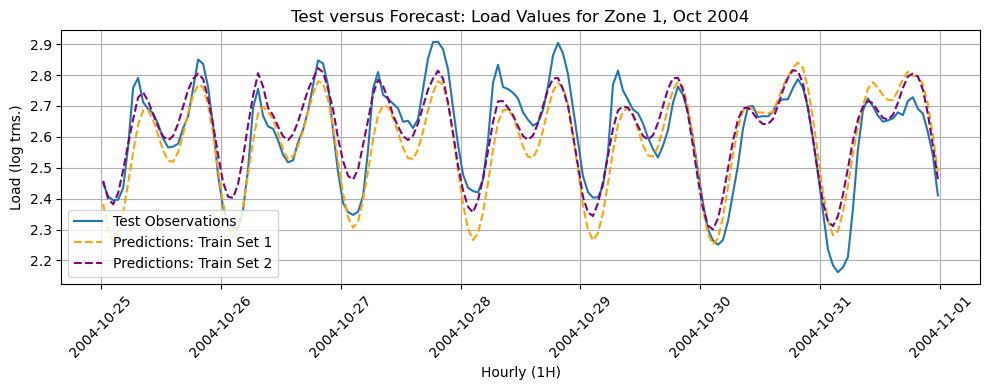

In [45]:
# Defining feature space and dependent variable - test set
y_test = load_long_z1_2004_oct_test["log_load_rs"]
X_test = load_long_z1_2004_oct_test[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]

# Predicted Values - Both Models
y_pred1 = np.ravel(np.array(load_long_z1_2004_oct_train_reg.predict(X_test)))
y_pred2 = np.ravel(np.array(load_long_z1_2004_nov_train_reg.predict(X_test)))

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=np.ravel(np.array(load_long_z1_2004_oct_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred1, x=load_long_z1_2004_oct_test.index, linestyle = '--', color='orange', label="Predictions: Train Set 1")
sns.lineplot(y=y_pred2, x=load_long_z1_2004_oct_test.index, linestyle = '--', color='purple', label="Predictions: Train Set 2")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

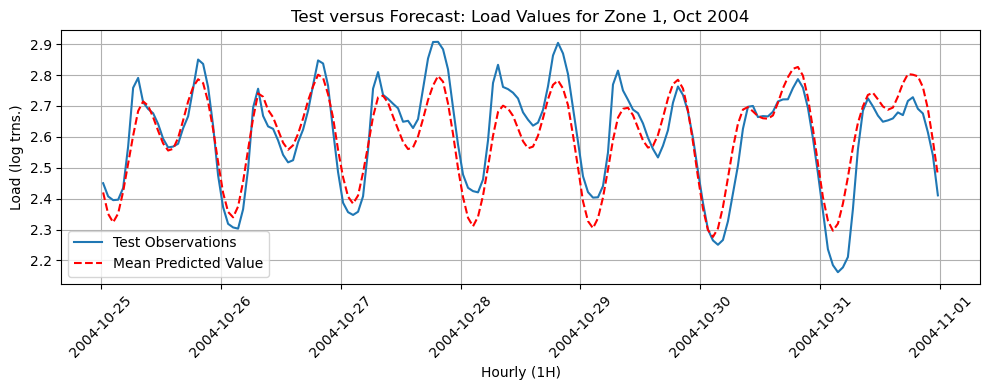

In [33]:
# Fit on the test data - from mean prediction
y_pred = (y_pred1 + y_pred2) / 2

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_oct_test, x=load_long_z1_2004_oct_test.index, y=np.ravel(np.array(load_long_z1_2004_oct_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred, x=load_long_z1_2004_oct_test.index, linestyle = '--', color='red', label="Mean Predicted Value")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Oct 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [34]:
# Averaging both predictions and testing performance on test
y_pred = (y_pred1 + y_pred2) / 2

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.793386551051148
MSE score: 0.005834258956011669
MAE score: 0.06189208126603277
MAPE score: 0.024022940742276462


Performance has improved.

In [35]:
# if first half of predictions come from set 1 and other half from set 2, does it improve performance?

print(f"R2 score: {r2_score(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}")
print(f'MSE score: {mean_squared_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAE score: {mean_absolute_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')

R2 score: 0.7363682529054008
MSE score: 0.007444316376309225
MAE score: 0.06549796211002737
MAPE score: 0.02537463343410434


Performance not better than averaged prediction.

In [46]:
# Can combined training improve test performance?

## Combined training - training set 1 + training set 2
load_long_z1_2004_oct_train_com = pd.concat([load_long_z1_2004_oct_train, load_long_z1_2004_nov_train])

## Fitting Linear Regression Model - combined training
X_train_com = load_long_z1_2004_oct_train_com[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train_com = np.array(load_long_z1_2004_oct_train_com.log_load_rs).reshape(-1, 1)
load_long_z1_2004_oct_train_com_reg = LinearRegression().fit(X_train_com, y_train_com)

## Predicting
y_pred = np.ravel(np.array(load_long_z1_2004_oct_train_com_reg.predict(X_test)))

## Performance on test
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.8056619295575308
MSE score: 0.00548763226082966
MAE score: 0.060345256398792166
MAPE score: 0.023450594553563055


Performance better than above 2 cases.

### Testing on Last Week of Dec 2004 (Zone 1)
Data for 2005 also needed for future values.

#### Processing Future Values

In [47]:
# Filtering load for 2005
load_long_z1_2005 = load_long_z1.loc[load_long_z1.year == 2005, ['timestamp','year','month','day','hour','log_load_rs']]

# Filtering temperature for 2005
temperature_2005 = temperature.loc[(temperature.timestamp > '2004-12-31 23:30:00') & (temperature.timestamp <= '2005-12-31 23:30:00'), ['timestamp', 'temp_weighted']]

# Combining load and temperature information
mul_df_2005 = load_long_z1_2005.merge(temperature_2005, on='timestamp', how='left')

# Adding holiday column
mul_df_2005["holiday"] = 0

# Adding holiday information - for 2005
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-01-17 23:30:00") & (mul_df_2005.timestamp >= "2005-01-17 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-02-21 23:30:00") & (mul_df_2005.timestamp >= "2005-02-21 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-05-30 23:30:00") & (mul_df_2005.timestamp >= "2005-05-30 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-07-04 23:30:00") & (mul_df_2005.timestamp >= "2005-07-04 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-09-05 23:30:00") & (mul_df_2005.timestamp >= "2005-09-05 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-10-10 23:30:00") & (mul_df_2005.timestamp >= "2005-10-10 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-11-11 23:30:00") & (mul_df_2005.timestamp >= "2005-11-11 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-11-24 23:30:00") & (mul_df_2005.timestamp >= "2005-11-24 00:30:00"),"holiday"] = 1
mul_df_2005.loc[(mul_df_2005.timestamp <= "2005-12-26 23:30:00") & (mul_df_2005.timestamp >= "2005-12-26 00:30:00"),"holiday"] = 1
mul_df_2005.head()

,timestamp,year,month,day,hour,log_load_rs,temp_weighted,holiday
0,2005-01-01 00:30:00,2005,1,1,00:30,2.609996,50.638756,0
1,2005-01-01 01:30:00,2005,1,1,01:30,2.578549,50.362884,0
2,2005-01-01 02:30:00,2005,1,1,02:30,2.540814,50.629541,0
3,2005-01-01 03:30:00,2005,1,1,03:30,2.531870,49.800186,0
4,2005-01-01 04:30:00,2005,1,1,04:30,2.553577,48.428932,0


In [48]:
# Adding temperature knots for PLR

T_H = 55  # Heating Threshold
T_C = 65  # Cooling Threshold

# Construct the Heating Demand Knot: HDK = max(0, T_H - Temp)
## This captures load increase when temp is below T_H.
mul_df_2005["HDK"] = np.where(
    mul_df_2005["temp_weighted"] < T_H,  
    T_H - mul_df_2005["temp_weighted"],  # Value if True: The positive difference
    0                               # Value if False: Zero
)

# Construct the Cooling Demand Knot; CDK = max(0, Temp - T_C)
## This captures load increase when temp is above T_C.
mul_df_2005["CDK"] = np.where(
    mul_df_2005["temp_weighted"] > T_C,  
    mul_df_2005["temp_weighted"] - T_C,  # Value if True: The positive difference
    0                               # Value if False: Zero
)

mul_df_2005.head()

,timestamp,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK
0,2005-01-01 00:30:00,2005,1,1,00:30,2.609996,50.638756,0,4.361244,0.0
1,2005-01-01 01:30:00,2005,1,1,01:30,2.578549,50.362884,0,4.637116,0.0
2,2005-01-01 02:30:00,2005,1,1,02:30,2.540814,50.629541,0,4.370459,0.0
3,2005-01-01 03:30:00,2005,1,1,03:30,2.531870,49.800186,0,5.199814,0.0
4,2005-01-01 04:30:00,2005,1,1,04:30,2.553577,48.428932,0,6.571068,0.0


#### Resuming back to Time Series Regression

In [49]:
# Creating training data 1
load_long_z1_2004_dec_train = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.set_index("timestamp")
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train[:'2004-12-24 23:30:00']
load_long_z1_2004_dec_train.index = pd.to_datetime(load_long_z1_2004_dec_train.index)

# Creating training data 2
load_long_z1_2005_jan_train = mul_df_2005.loc[mul_df_2005.month == 1,:]
load_long_z1_2005_jan_train = load_long_z1_2005_jan_train.set_index("timestamp")
load_long_z1_2005_jan_train = load_long_z1_2005_jan_train[:'2005-01-21 23:30:00']
load_long_z1_2005_jan_train.index = pd.to_datetime(load_long_z1_2005_jan_train.index)

# Adding periodicities
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.deterministic import DeterministicProcess
periodicity = Fourier(period=24, order=2) # daily cycle i.e. 24 hours, 2 harmonics

# Defining the sine wave (training set 1)
dp1 = DeterministicProcess(
    index=load_long_z1_2004_dec_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves1 = dp1.in_sample()

# Defining the sine wave (training set 2)
dp2 = DeterministicProcess(
    index=load_long_z1_2005_jan_train.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # defined later
    order=1,             # linear trend not required since seasonal diff made the series stationary
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves2 = dp2.in_sample()

# Combining fourier terms with other variables
load_long_z1_2004_dec_train = load_long_z1_2004_dec_train.merge(waves1, on='timestamp', how='left')
load_long_z1_2005_jan_train = load_long_z1_2005_jan_train.merge(waves2, on='timestamp', how='left')

In [50]:
# Fitting Linear Regression Model - training set 1 
from sklearn.linear_model import LinearRegression

X_train1 = load_long_z1_2004_dec_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train1 = np.array(load_long_z1_2004_dec_train.log_load_rs).reshape(-1, 1)
load_long_z1_2004_dec_train_reg = LinearRegression().fit(X_train1, y_train1)

# Fitting Linear Regression Model - training set 2
X_train2 = load_long_z1_2005_jan_train[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train2 = np.array(load_long_z1_2005_jan_train.log_load_rs).reshape(-1, 1)
load_long_z1_2005_jan_train_reg = LinearRegression().fit(X_train2, y_train2)

In [51]:
# Creating test data
load_long_z1_2004_dec_test = mul_df.loc[mul_df.month == 12,:]
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.set_index("timestamp")
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test['2004-12-25 00:30:00':]
load_long_z1_2004_dec_test.index = pd.to_datetime(load_long_z1_2004_dec_test.index)

# Defining the sine wave
dp = DeterministicProcess(
    index=load_long_z1_2004_dec_test.index,
    period=None,         # It's not defined so that frequency can be read from the index
    constant=False,      # Let regression model define this intercept later on
    order=1,             # linear trend needed 
    seasonal=False,      # no seasonal dummies
    additional_terms=[periodicity], # 2 seperate waves will be generated
    drop=True            # if perfect collinearity exists, the terms can be dropped
)

waves = dp.in_sample()

# Combining fourier terms with other variables - test set
load_long_z1_2004_dec_test = load_long_z1_2004_dec_test.merge(waves, on='timestamp', how='left')
load_long_z1_2004_dec_test.head()

,year,month,day,hour,log_load_rs,temp_weighted,holiday,HDK,CDK,trend,"sin(1,24)","cos(1,24)","sin(2,24)","cos(2,24)"
timestamp,,,,,,,,,,,,,,
2004-12-25 00:30:00,2004,12,25,00:30,3.270443,25.586955,0,29.413045,0.0,1.0,0.000000,1.000000,0.000000,1.000000e+00
2004-12-25 01:30:00,2004,12,25,01:30,3.272530,24.675567,0,30.324433,0.0,2.0,0.258819,0.965926,0.500000,8.660254e-01
2004-12-25 02:30:00,2004,12,25,02:30,3.290191,24.681275,0,30.318725,0.0,3.0,0.500000,0.866025,0.866025,5.000000e-01
2004-12-25 03:30:00,2004,12,25,03:30,3.314804,24.588997,0,30.411003,0.0,4.0,0.707107,0.707107,1.000000,6.123234e-17
2004-12-25 04:30:00,2004,12,25,04:30,3.350676,24.320518,0,30.679482,0.0,5.0,0.866025,0.500000,0.866025,-5.000000e-01


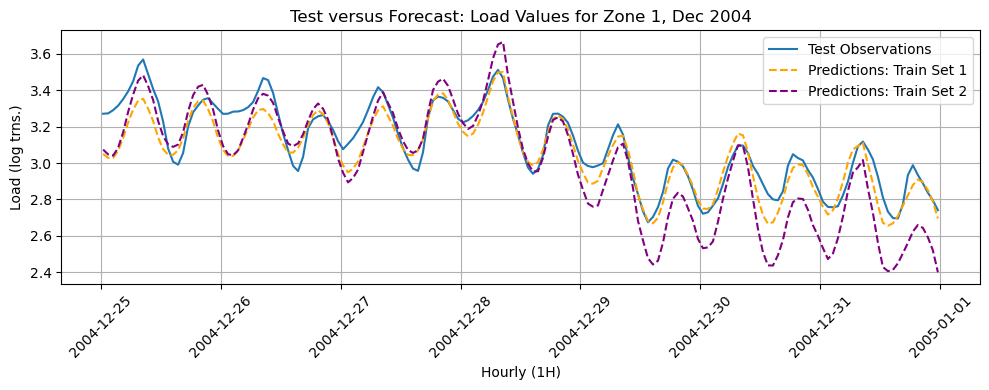

In [52]:
# Defining feature space and dependent variable - test set
y_test = load_long_z1_2004_dec_test["log_load_rs"]
X_test = load_long_z1_2004_dec_test[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]

# Predicted Values - Both Models
y_pred1 = np.ravel(np.array(load_long_z1_2004_dec_train_reg.predict(X_test)))
y_pred2 = np.ravel(np.array(load_long_z1_2005_jan_train_reg.predict(X_test)))

# Fit on the test data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=np.ravel(np.array(load_long_z1_2004_dec_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred1, x=load_long_z1_2004_dec_test.index, linestyle = '--', color='orange', label="Predictions: Train Set 1")
sns.lineplot(y=y_pred2, x=load_long_z1_2004_dec_test.index, linestyle = '--', color='purple', label="Predictions: Train Set 2")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

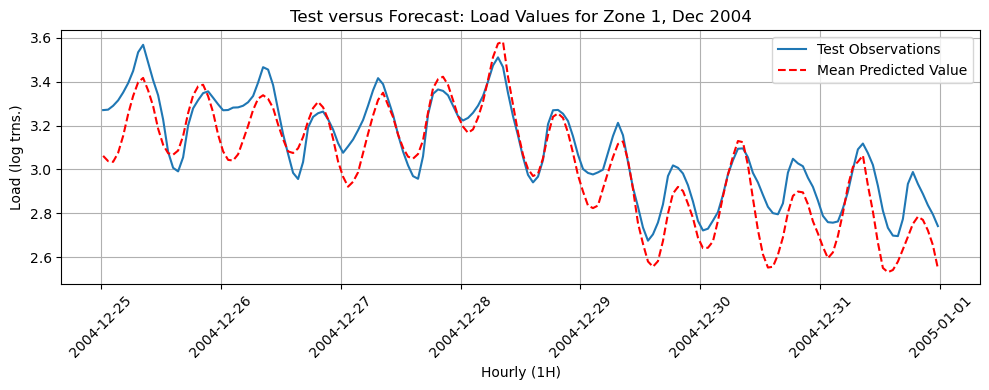

In [53]:
# Fit on the test data - from mean prediction
y_pred = (y_pred1 + y_pred2) / 2

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=load_long_z1_2004_dec_test, x=load_long_z1_2004_dec_test.index, y=np.ravel(np.array(load_long_z1_2004_dec_test["log_load_rs"])), label="Test Observations", ax=ax)
sns.lineplot(y=y_pred, x=load_long_z1_2004_dec_test.index, linestyle = '--', color='red', label="Mean Predicted Value")
ax.set_title("Test versus Forecast: Load Values for Zone 1, Dec 2004")
ax.set_xlabel("Hourly (1H)")
ax.set_ylabel("Load (log trns.)")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [54]:
# Averaging both predictions and testing performance on test
y_pred = (y_pred1 + y_pred2) / 2

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.6840221151957384
MSE score: 0.014826820266700886
MAE score: 0.09979243939443691
MAPE score: 0.032675139771682925


Performance has decreased, but is still better than the 2 cases ahead.

In [55]:
# if first half of predictions come from set 1 and other half from set 2, does it improve performance?

print(f"R2 score: {r2_score(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}")
print(f'MSE score: {mean_squared_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAE score: {mean_absolute_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, np.concatenate((y_pred1[:84], y_pred2[-84:])))}')

R2 score: 0.3588614970277666
MSE score: 0.030084527452038854
MAE score: 0.13970329383251437
MAPE score: 0.0464325885285452


Performance detoriated very badly

In [57]:
# Can combined training improve test performance?

## Combined training - training set 1 + training set 2
load_long_z1_2004_dec_train_com = pd.concat([load_long_z1_2004_dec_train, load_long_z1_2005_jan_train])

## Fitting Linear Regression Model - combined training
X_train_com = load_long_z1_2004_dec_train_com[['CDK', 'HDK', 'holiday', 'trend', 'sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)']]
y_train_com = np.array(load_long_z1_2004_dec_train_com.log_load_rs).reshape(-1, 1)
load_long_z1_2004_dec_train_com_reg = LinearRegression().fit(X_train_com, y_train_com)

## Predicting
y_pred = np.ravel(np.array(load_long_z1_2004_dec_train_com_reg.predict(X_test)))

## Performance on test
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}')

R2 score: 0.5544993570460995
MSE score: 0.020904494521409245
MAE score: 0.11928513274295578
MAPE score: 0.038604056201055045


Performance is still very poor.

## Conclusion
The only two cases that make the most sense are:
- Average the predictions from both the training sets
- Train on the combined training set

> Best Solution: Average the predictions from both the training sets
> - Performs slightly better than the original case where training set 2 wasn't considered.